In [1]:
USE_COLAB = True

In [2]:
import os
import sys

In [3]:
if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # go to the drive directory
    ROOT_PATH = '/content/drive/MyDrive/EPFL/Machine Learning/ml-project-2-odds-oddities'
    %cd $ROOT_PATH

else:
    ROOT_PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)

sys.path.append(ROOT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EPFL/Machine Learning/ml-project-2-odds-oddities


In [4]:
import cv2
import torch
import albumentations as A
import segmentation_models_pytorch as smp

from scripts.evaluation import get_test_f1, save_csv_aicrowd
from scripts.plotting import plot_metric_per_epoch, plot_n_predictions
from scripts.preprocessing import RoadDataset, split_data
from scripts.training import train_model
from torch.utils.data import DataLoader

In [5]:
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

In [6]:
# define transformations
train_transform = A.Compose([
    A.Resize(height=608, width=608, always_apply=True),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.Rotate(p=0.5, limit=180, border_mode=cv2.BORDER_CONSTANT, rotate_method="ellipse"),
    # A.RandomBrightnessContrast(p=0.5),
    # A.RandomSnow(p=0.1)
])

test_transform = A.Compose([A.Resize(height=608, width=608, always_apply=True)])

In [7]:
image_path_train, image_path_test, mask_path_train, mask_path_test = split_data(train_directory, 0.1)
# get train and val dataset instances
train_dataset = RoadDataset(image_path_train, mask_path_train, train_transform)
test_dataset = RoadDataset(image_path_test, mask_path_test, test_transform)

In [8]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

SEED = 13
BATCH_SIZE = 4
N_CPU = os.cpu_count()
N_EPOCHS = 50

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE,
    'num_workers': N_CPU,
    'persistent_workers': True
}

In [9]:
train_set, val_set = torch.utils.data.random_split(train_dataset, lengths=[0.8, 0.2])

train_loader = DataLoader(train_set, **LOADER_PARAMS)
valid_loader = DataLoader(val_set, **LOADER_PARAMS)

In [10]:
model_ = smp.create_model("FPN", encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)
criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)
scheduler_ = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer_,
        T_max=(len(train_loader.dataset) * N_EPOCHS) // train_loader.batch_size,
    )

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


In [11]:
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model_, (train_loader, valid_loader), criterion_, optimizer_, scheduler_, N_EPOCHS
)

Epoch:   1. Train.      Loss: 0.503 | f1: 0.484: 100%|██████████| 18/18 [00:14<00:00,  1.23it/s]
Epoch:   1. Validation. Loss: 0.546 | f1: 0.432: 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]
Epoch:   2. Train.      Loss: 0.288 | f1: 0.692: 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
Epoch:   2. Validation. Loss: 0.309 | f1: 0.662: 100%|██████████| 5/5 [00:00<00:00,  8.19it/s]
Epoch:   3. Train.      Loss: 0.214 | f1: 0.764: 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]
Epoch:   3. Validation. Loss: 0.218 | f1: 0.757: 100%|██████████| 5/5 [00:00<00:00,  7.21it/s]
Epoch:   4. Train.      Loss: 0.175 | f1: 0.800: 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]
Epoch:   4. Validation. Loss: 0.170 | f1: 0.795: 100%|██████████| 5/5 [00:00<00:00,  8.02it/s]
Epoch:   5. Train.      Loss: 0.151 | f1: 0.828: 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]
Epoch:   5. Validation. Loss: 0.178 | f1: 0.770: 100%|██████████| 5/5 [00:00<00:00,  6.99it/s]
Epoch:   6. Train.      Loss: 0.132 | f1

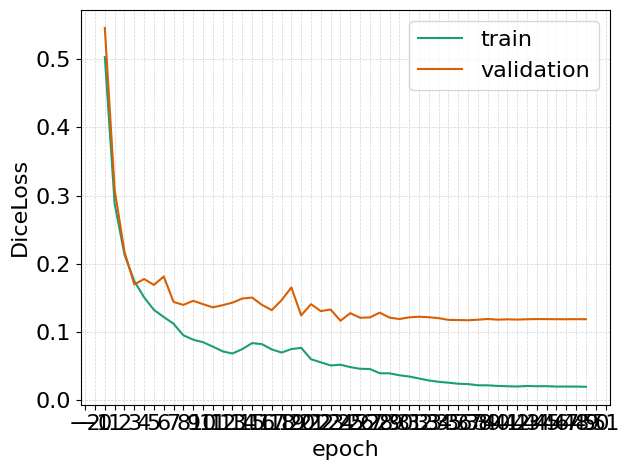

In [12]:
plot_metric_per_epoch(train_losses, valid_losses, 'DiceLoss')

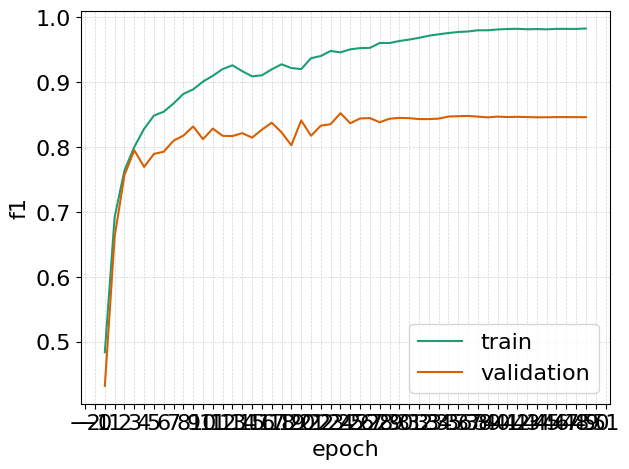

In [13]:
plot_metric_per_epoch(train_f1s, valid_f1s, 'f1')

f1: 0.18


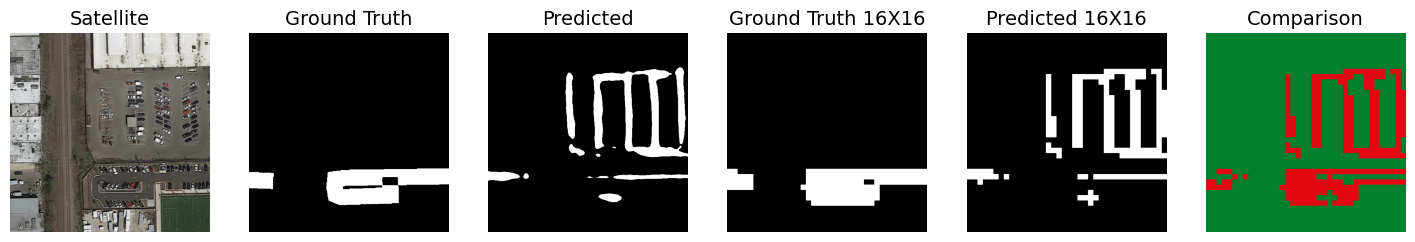

f1: 0.91


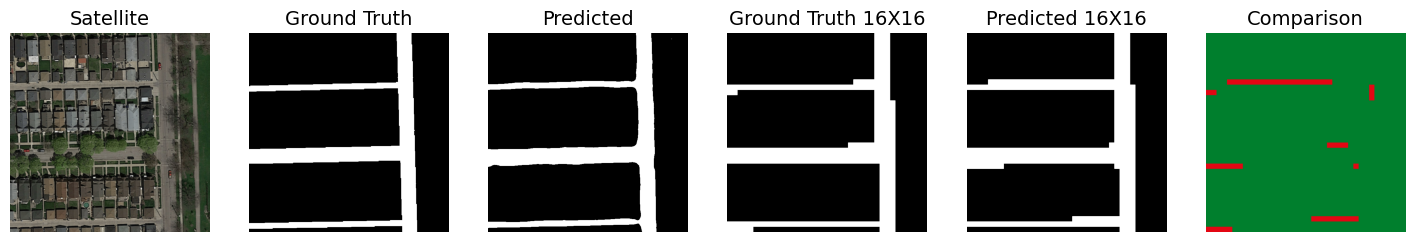

f1: 0.78


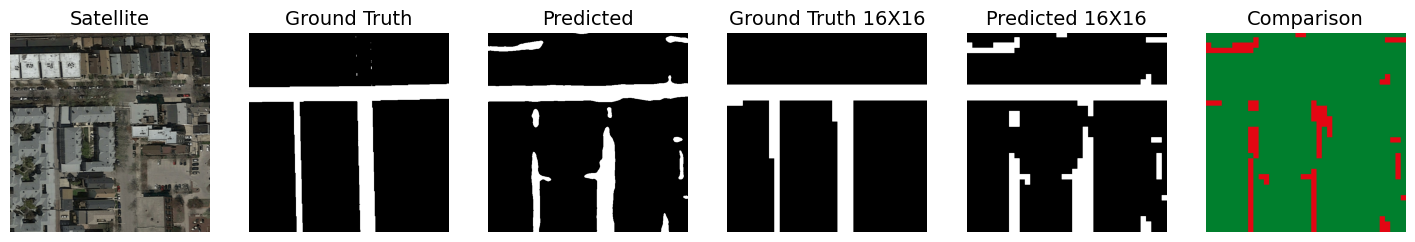

f1: 0.97


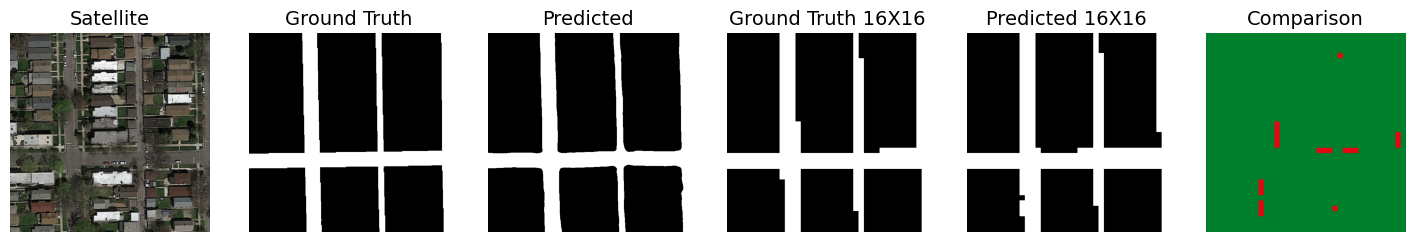

f1: 0.80


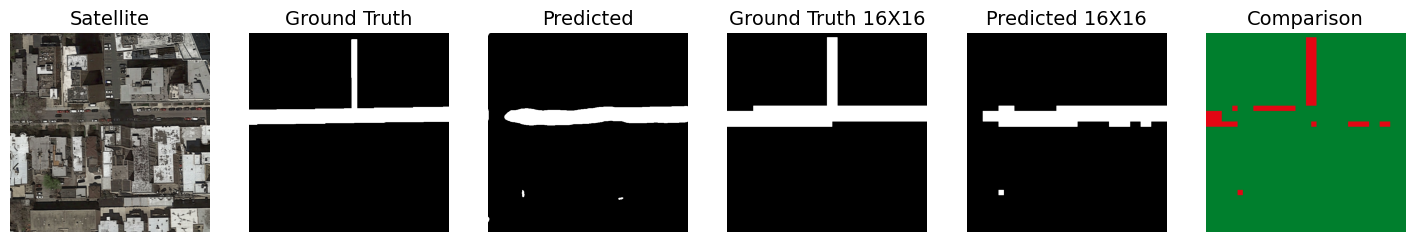

In [14]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
plot_n_predictions(model_, test_loader)

In [15]:
'f1 score for the test dataset {:.3f}.'.format(get_test_f1(model_, test_loader))

'f1 score for the test dataset 0.865.'